<h1>Analisis y modelado del crédito bancario al sector privado</h1>

Utilizamos este docuemnto para hacer el analisis y modelado de la serie de tiempo del credito bancario al sector privado. Para el modelado utilizamos un enfoque de aprendizaje profundo tipo encoder-decoder, usando LSTM como encoder y MLP's como decoders, la arquitectura del modelo se encuentra en la carpeta arquitectura_modelos.

Las series de tiempo se obtienen por medio de la API Banco de México con el propósito de que se puedan obtener y ajustar la estimación rápidamente ante la actualización de estas series.

In [127]:
from pathlib import Path
import os

os.chdir('C:/ABM/Analisis/Estimacion_Credito_Seq2seq')

# Buscar el primer directorio padre que contenga un archivo específico
def find_project_root(filename="requirements.txt"):
    current = Path().resolve()
    for parent in [current] + list(current.parents):
        if (parent / filename).exists():
            return parent
    raise FileNotFoundError(f"No se encontró {filename} en ningún directorio padre.")

# Establecer como root
os.chdir(find_project_root())
print("Nuevo directorio:", os.getcwd())

Nuevo directorio: C:\ABM\Analisis\Estimacion_Credito_Seq2seq


In [ ]:
# Importar librerias 

import numpy as np
import pandas as pd

from datetime import datetime
from pandas.tseries.frequencies import to_offset

import matplotlib.pyplot as plt

from dotenv import load_dotenv

# Pytorch para redes neuroanles
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl

# Importamos modulos propios
from api_caller.banxico import Banxico_SIE
from api_caller.inegi import INEGI_BIE

from arquitectura_modelos import MultivariateTimeSeriesDataset, Seq2seq_MultiHorizon_Quantile_Recurrent_Forecaster
from arquitectura_modelos.set_seed import set_seed


# Evitamos mensajes de advertencia
import warnings
warnings.filterwarnings("ignore")

In [129]:
# Carga variables de un archivo .env (para almacenar el token de la API de Banxico)
load_dotenv()

# Token
BANXICO_TOKEN = os.environ.get("Banxico_Token")
INEGI_TOKEN = os.environ.get("INEGI_Token") 

banxico_api = Banxico_SIE(BANXICO_TOKEN)
inegi_api = INEGI_BIE(INEGI_TOKEN)

# Lectura de series

In [130]:
# Descarga de series de banxico
fecha_inicio = '1994-03-01'

series_dict = {'SP1':'INPC', 'SR17622':'PIB', 'SR17693':'IGAE',
               'SF17908':'TC_fix',
               'SF17863':'Tasa_fondeo_bancario',
               'SF311410':'Captacion_bancaria_dep_exig',
               'SF235401':'Credito_consumo', 'SF235410':'Credito_vivienda', 'SF235418':'Credito_empresas',}

# Series
series_banxico = banxico_api.get_data(list(series_dict.keys()), fecha_inicio=fecha_inicio)

# Se ordenan las columnas, se verifica que los datos son numericos y se cambia el nombre de las series
series_banxico = series_banxico.sort_index(axis=1)
series_banxico = series_banxico.apply(pd.to_numeric, errors='coerce')
series_banxico = series_banxico.rename(columns=series_dict)

# Calculamos la media mensual de la serie en caso de tener series con mayor desagregacion
series_banxico = series_banxico.resample('MS').mean()

In [131]:
# Descarga de series de inegi
series_dict = {'444559':'Poblacion_ocupada',
               '454168':'Confianza_consumidor'}

#Series
series_inegi = inegi_api.get_data(list(series_dict.keys()), last_data=False)

# Se ordenan las columnas, se verifica que los datos son numericos y se cambia el nombre de las series
series_inegi = series_inegi.sort_index(axis=1)
series_inegi = series_inegi.apply(pd.to_numeric, errors='coerce')
series_inegi = series_inegi.rename(columns=series_dict)

# Calculamos la media mensual de la serie en caso de tener series con mayor desagregacion
series_inegi = series_inegi.resample('MS').mean()

In [132]:
# Conccatenamos las series de banxico e inegi
series = pd.concat([series_banxico,series_inegi],join='outer',axis=1)

In [133]:
# Calculamos el credito total al sector privado y dividimos por inpc para obtener el credito real
series['Credito_consumo_real'] = series['Credito_consumo'] / series['INPC']
series['Credito_vivienda_real'] = series['Credito_vivienda'] / series['INPC']
series['Credito_empresas_real'] = series['Credito_empresas'] / series['INPC']


series['Credito_SP'] = series['Credito_consumo'] + series['Credito_vivienda'] + series['Credito_empresas']
series['Credito_SP_real'] = series['Credito_consumo_real'] + series['Credito_vivienda_real'] + series['Credito_empresas_real']

In [134]:
print(series.head())

            Tasa_fondeo_bancario  TC_fix  Credito_consumo  Credito_vivienda  \
1994-03-01                   NaN  3.2841              NaN               NaN   
1994-04-01                   NaN  3.3536              NaN               NaN   
1994-05-01                   NaN  3.3120              NaN               NaN   
1994-06-01                   NaN  3.3607              NaN               NaN   
1994-07-01                   NaN  3.4009              NaN               NaN   

            Credito_empresas  Captacion_bancaria_dep_exig       INPC  \
1994-03-01               NaN                          NaN  14.094225   
1994-04-01               NaN                          NaN  14.163251   
1994-05-01               NaN                          NaN  14.231682   
1994-06-01               NaN                          NaN  14.302895   
1994-07-01               NaN                          NaN  14.366327   

                   PIB     IGAE  Poblacion_ocupada  Confianza_consumidor  \
1994-03-01      

# Procesamiento

In [135]:
# Quitamos los nan del inicio del dataframe
series = series[series['Credito_SP'].dropna().index.min():]

In [136]:
# Calculamos variaciones anuales de series de interés
series['IGAE_var'] = np.log(series['IGAE']).diff(12)*100
series['Credito_consumo_real_var'] = np.log(series['Credito_consumo_real']).diff(12)*100
series['Credito_vivienda_real_var'] = np.log(series['Credito_vivienda_real']).diff(12)*100
series['Credito_empresas_real_var'] = np.log(series['Credito_empresas_real']).diff(12)*100
series['Credito_SP_real_var'] = np.log(series['Credito_SP_real']).diff(12)*100

series['Confianza_consumidor_var'] = np.log(series['Confianza_consumidor']).diff(12)*100


In [137]:
# Obtenemos la distribucion del credito por segmento
dist_cred = series.copy().loc[:,['Credito_consumo','Credito_vivienda','Credito_empresas']]
dist_cred = dist_cred.loc[dist_cred.dropna().index]
dist_cred = dist_cred.iloc[-1,:]
dist_cred = dist_cred/dist_cred.sum()

print(dist_cred)

Credito_consumo     0.296021
Credito_vivienda    0.243573
Credito_empresas    0.460406
Name: 2025-06-01 00:00:00, dtype: float64


In [138]:
print(series.head())

            Tasa_fondeo_bancario  TC_fix  Credito_consumo  Credito_vivienda  \
1994-12-01                   NaN  3.9308          46650.6          101043.8   
1995-01-01                 45.08  5.5133          45243.7          103028.7   
1995-02-01                 51.98  5.6854          44754.3          105394.0   
1995-03-01                 76.88  6.7019          44037.1          108861.3   
1995-04-01                 82.79  6.2996          43891.9          113524.3   

            Credito_empresas  Captacion_bancaria_dep_exig       INPC  \
1994-12-01          252525.6                          NaN  14.819204   
1995-01-01          252492.6                          NaN  15.376991   
1995-02-01          251151.7                          NaN  16.028707   
1995-03-01          251259.7                          NaN  16.973617   
1995-04-01          254548.8                          NaN  18.326133   

                   PIB     IGAE  Poblacion_ocupada  ...  \
1994-12-01  14754286.1  60.5128  

# Preparacion para entrenamiento

In [139]:
# Separamos las series objetivo y exógenas
series_objetivo = ['Credito_consumo_real_var','Credito_vivienda_real_var','Credito_empresas_real_var', 'Credito_SP_real_var']
series_exogenas = ['IGAE_var']
series_input = series_objetivo + series_exogenas

In [ ]:
# Dataframe con las series de interes para introducirlas al modelo
df = series.copy().loc[:, series_input]
df = df[df.dropna().index.min():]

# Definimos el periodo de entrenamiento y validacion
rezago_anos = 2

last_date = df.index.max()
train_date = last_date + pd.DateOffset(months=-12*rezago_anos)
validation_date = last_date + pd.DateOffset(months=-12*(rezago_anos-1)//2)

# Separamos los datos de entrenamiento y validacion para el modelo de Seq2seq
df_train = df.loc[:train_date, :]
df_val = df.loc[:validation_date, :]
df_test = df.loc[:last_date, :]

print(f'Datos de entrenamiento desde {df.index.min().strftime('%Y-%m')}')
print('\n')
print(f"Datos de entrenamiento hasta el: {train_date.strftime('%Y-%m')}")
print(f"Datos de validacion hasta el: {validation_date.strftime('%Y-%m')}")
print(f"Datos de prueba hasta el: {last_date.strftime('%Y-%m')}")

Datos de entrenamiento desde 1995-12


Datos de entrenamiento hasta el: 2023-07
Datos de validacion hasta el: 2025-01
Datos de prueba hasta el: 2025-07


# Parametros

In [141]:
# Parametros de historia, horizonte de pronostico y batch size
hist_len = 12*4
horizon = 12*2
batch_size = 10

# Parametro para agregar un lag sobre la propia variable objetivo con intencion de capturar mejor la tendencia y estrutura de largo plazo
lag = 12

# Definimos variables de cambio de tendencia a partir de fecha designada (shock)
shock_dict = None   # {'covid': pd.to_datetime('2020-03-01'),} # Ejemplo de como se llena

# Auxiliares para calculo de variables de entrada
len_shock_dict = len(shock_dict) if shock_dict is not None else 0
len_lag = 1 if lag>0 else 0

# Parametros de variables de entrada y salida
input_size = len(series_exogenas) + 5 + len_shock_dict + len_lag # Exogenas + objetivo + time features + shocks + lag
output_size = 1

# Parametros de tamaño de estado oculto y capas para el encoder LSTM
hidden_size = 128
num_layers = 2

# Parametros para capas MLP y contextos
global_mlp_layers = 300
ca_size = hidden_size
ct_size = hidden_size // 2
local_mlp_layers = 300

# Parametros de embedding para identificacion de series
num_embeddings = len(series_objetivo)
embedding_dim = 10*num_embeddings

# Parametro auxiliar para entrenamiento (ayuda a capturar estructura en periodos mas cortos durante el entrenamiento)
min_hist_len = 4

# Variable de cuantiles
quantiles = [0.05, 0.5, 0.95]

# Parámetros de optimización
learning_rate = 1e-4


set_seed()

In [142]:
# Dataset de entrenamiento
train_dataset = MultivariateTimeSeriesDataset(
    df = df_train,
    target_cols = series_objetivo,
    exog_cols = series_exogenas,
    hist_len = hist_len,
    horizon = horizon,
    shock_dict = shock_dict,
    lag = lag
)

# DataLoader en entrenamiento
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Dataset de validación
val_dataset = MultivariateTimeSeriesDataset(
    df = df_val,
    target_cols = series_objetivo,
    exog_cols = series_exogenas,
    hist_len = hist_len,
    horizon = horizon,
    shock_dict = shock_dict,
    mean = train_dataset.mean,
    std = train_dataset.std,
    lag = train_dataset.lag
)

# DataLoader en validación
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


In [143]:
# Verificacion del shape de val_dataloader
for x_hist, x_fut, y_hist, y_fut, series_idx in iter(train_dataloader):
    print('\nShapes of the training batch:')
    print(f'x_hist: {x_hist.shape}')
    print(f'x_fut: {x_fut.shape}')
    print(f'y_hist: {y_hist.shape}')
    print(f'y_fut: {y_fut.shape}')
    print(f'series_idx: {series_idx}')
    break
    


Shapes of the training batch:
x_hist: torch.Size([10, 48, 6])
x_fut: torch.Size([10, 24, 6])
y_hist: torch.Size([10, 48, 1])
y_fut: torch.Size([10, 24, 1])
series_idx: tensor([2, 3, 1, 0, 1, 2, 1, 1, 0, 3])


# Entrenamiento

In [144]:
# Modelo
model = Seq2seq_MultiHorizon_Quantile_Recurrent_Forecaster(
    hist_len = hist_len,
    horizon = horizon,
    input_size = input_size,
    output_size = output_size,
    hidden_size = hidden_size,
    num_layers = num_layers,
    global_mlp_layers = global_mlp_layers,
    ct_size = ct_size,
    ca_size = ca_size,
    local_mlp_layers = local_mlp_layers,
    num_embeddings = num_embeddings,
    embedding_dim = embedding_dim,
    min_hist_len = min_hist_len,
    quantiles = quantiles,
    learning_rate = learning_rate,)

model.target_cols = series_objetivo
model.exog_cols = series_exogenas
model.mean = train_dataset.mean
model.std = train_dataset.std
model.shock_dict = train_dataset.shock_dict
model.series_id_map = train_dataset.series_id_map
model.lag = train_dataset.lag


In [145]:
# Verificacion de que el modelo funciona
batch = next(iter(train_dataloader))

x_hist, x_fut, y_hist, y_fut, series_idx = batch
y_hat, _, _ = model.forward(x_hist, x_fut, y_hist, series_idx)

# Vemos si hay nan
print("Shape de y_hat:", y_hat.shape)
print("Hay NaN en y_hat:", torch.isnan(y_hat).any().item())

Shape de y_hat: torch.Size([10, 24, 1, 3])
Hay NaN en y_hat: False


In [146]:
# Entrenamiento
epochs = 30

trainer = pl.Trainer(max_epochs=epochs)
trainer.fit(model, train_dataloader, val_dataloader)

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name             | Type       | Params | Mode 
--------------------------------------------------------
0 | series_embedding | Embedding  | 160    | train
1 | encoder          | LSTM       | 222 K  | train
2 | global_mlp       | Sequential | 870 K  | train
3 | local_mlp        | Sequential | 72.6 K | train
--------------------------------------------------------
1.2 M     Trainable params
0         Non-trainable params
1.2 M     Total params
4.665     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Epoch 29: 100%|██████████| 25/25 [00:10<00:00,  2.46it/s, v_num=91, train_loss_step=0.0266, val_QL=0.0271, train_loss_epoch=0.0308]

`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch 29: 100%|██████████| 25/25 [00:10<00:00,  2.44it/s, v_num=91, train_loss_step=0.0266, val_QL=0.0271, train_loss_epoch=0.0308]


# Validacion

In [ ]:
# Predicciones
initial_pred_date = pd.to_datetime("2023-03-01")

#initial_pred_date = validation_date + pd.DateOffset(months=1)  # Ajustamos la fecha de inicio de predicción
end_year_pred = datetime(initial_pred_date.year, 12, 1)
end_year_1_pred = datetime(initial_pred_date.year + 1, 12, 1)


In [ ]:
# Predicciones de todas las series
df_pred = df.copy()
for serie in series_objetivo:
    predicciones = model.predict(
    df = df,
    target_col = serie,
    initial_pred_date = initial_pred_date
    )
    df_pred = pd.concat([df_pred, predicciones], axis=1)


# Acotar el DataFrame a las fechas de interés
df_pred = df_pred.loc[initial_pred_date + pd.DateOffset(months=-12):(initial_pred_date + pd.DateOffset(months=12*2))]

df_pred['Credito_SP_2_real_var'] = df_pred['Credito_SP_real_var']

In [161]:
# Calculamos la variacion anual real del credito al sector privado ponderando las estimaciones por segmento
for quantile in quantiles:
    df_pred[f'Credito_SP_2_real_var_{int(quantile*100)}'] = (df_pred[f'Credito_consumo_real_var_{int(quantile*100)}']*dist_cred['Credito_consumo'] + 
                                                             df_pred[f'Credito_vivienda_real_var_{int(quantile*100)}']*dist_cred['Credito_vivienda'] + 
                                                             df_pred[f'Credito_empresas_real_var_{int(quantile*100)}']*dist_cred['Credito_empresas']
                                                             )

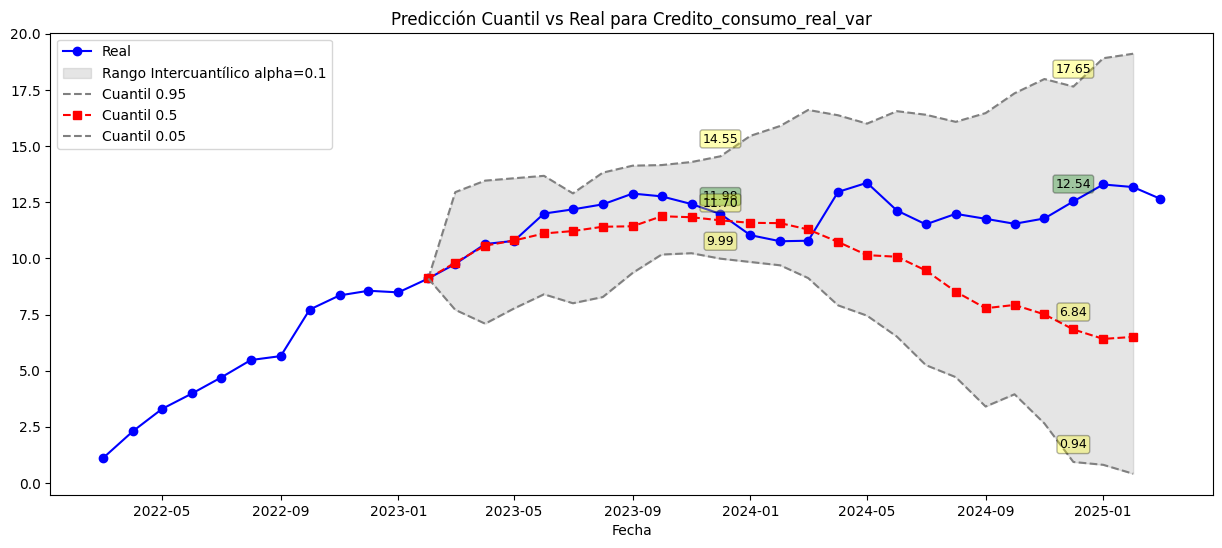

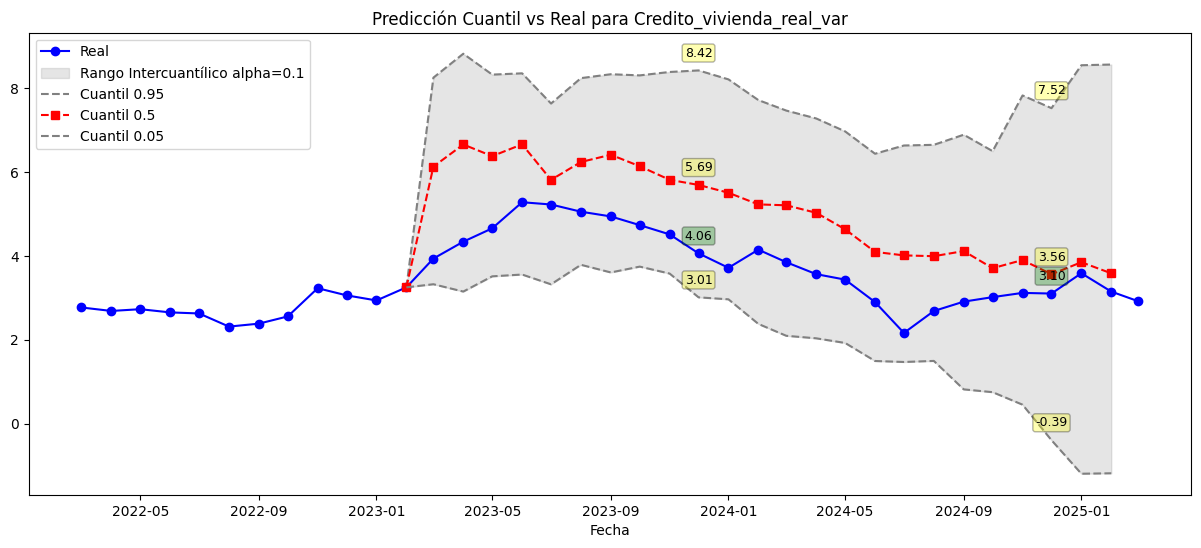

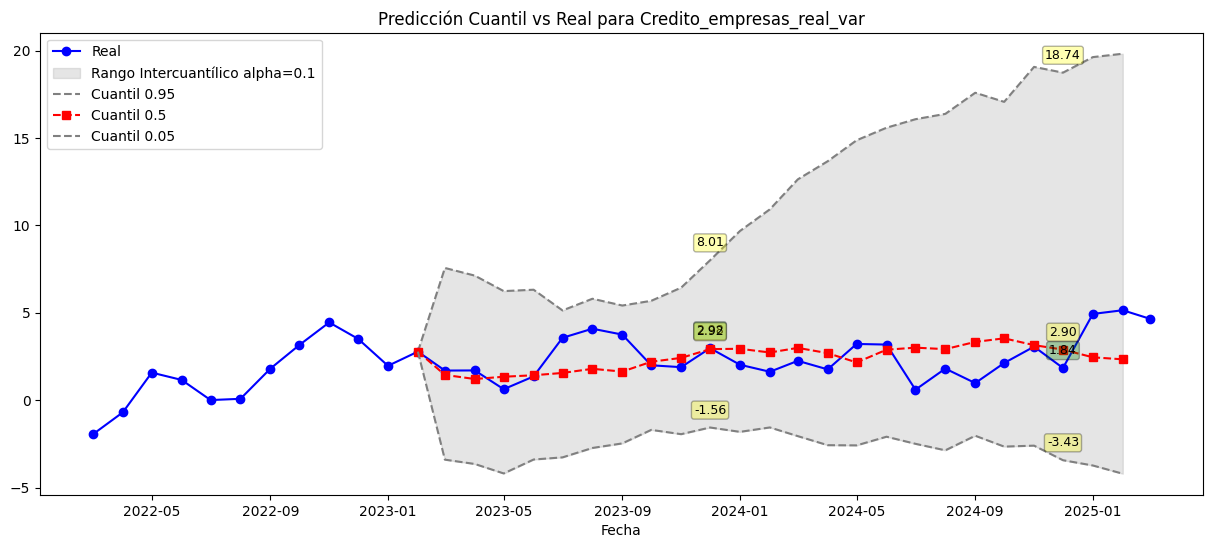

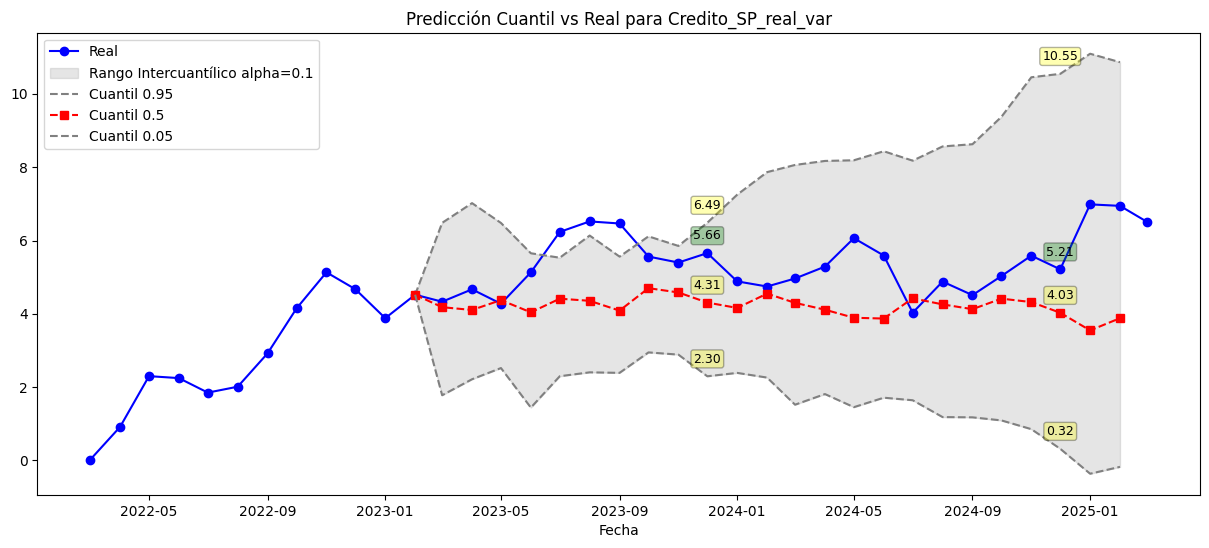

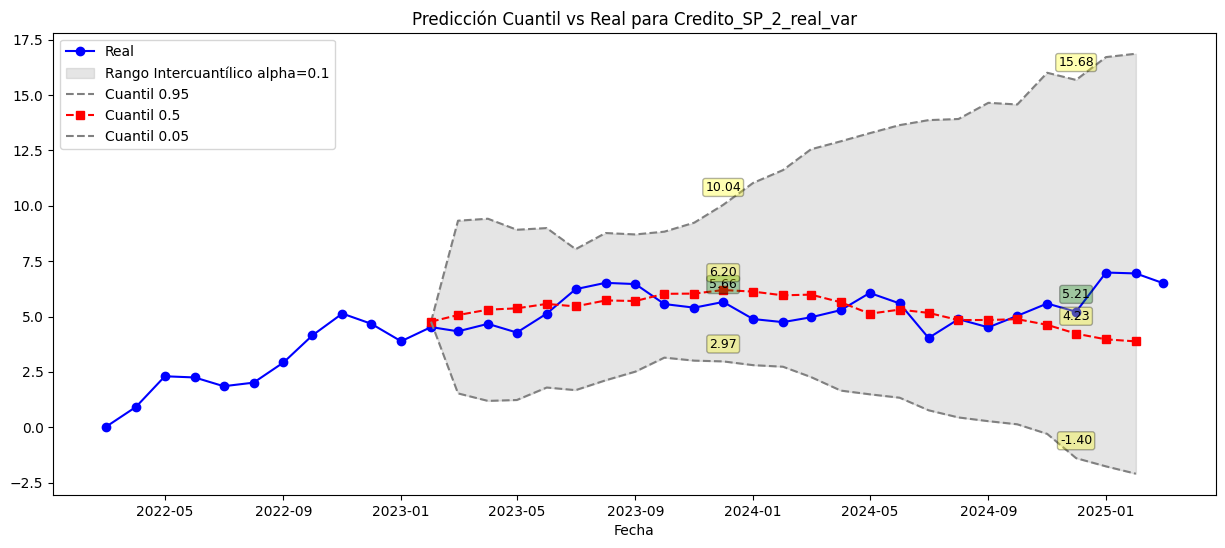

In [162]:
# Iterar sobre cada variable objetivo para crear una gráfica
for serie in (series_objetivo + ['Credito_SP_2_real_var']):
    fig, ax1 = plt.subplots(figsize=(15, 6))

    # Graficar la serie real
    plt.plot(df_pred.index, df_pred[serie], label='Real', marker='o', linestyle='-', color='blue')

    if end_year_pred in df_pred.index:
        valor = df_pred.at[end_year_pred, serie]
        ax1.annotate(f'{valor:.2f}', xy=(end_year_pred, valor), xytext=(0, 10),
                        textcoords='offset points', ha='center', fontsize=9,
                        bbox=dict(boxstyle='round,pad=0.2', fc='green', alpha=0.3))
        
    if end_year_1_pred in df_pred.index:
        valor = df_pred.at[end_year_1_pred, serie]
        ax1.annotate(f'{valor:.2f}', xy=(end_year_1_pred, valor), xytext=(0, 10),
                        textcoords='offset points', ha='center', fontsize=9,
                        bbox=dict(boxstyle='round,pad=0.2', fc='green', alpha=0.3))
        
    plt.fill_between(df_pred.index, df_pred[f'{serie}_{int(quantiles[0]*100)}'], df_pred[f'{serie}_{int(quantiles[-1]*100)}'], color='gray', alpha=0.2, label='Rango Intercuantílico alpha=0.1')


    for quantile, color in zip(quantiles[::-1], ['gray', 'red', 'gray']):
        col_name = f'{serie}_{int(quantile*100)}'
        if col_name in df_pred.columns:
            if col_name == f'{serie}_50':
                plt.plot(df_pred.index, df_pred[col_name], label=f'Cuantil {quantile}', marker='s', linestyle='--', color=color)
            else:
                plt.plot(df_pred.index, df_pred[col_name], label=f'Cuantil {quantile}', linestyle='--', color=color)

            if end_year_pred in df_pred.index:
                valor = df_pred.at[end_year_pred, col_name]
                ax1.annotate(f'{valor:.2f}', xy=(end_year_pred, valor), xytext=(0, 10),
                            textcoords='offset points', ha='center', fontsize=9,
                            bbox=dict(boxstyle='round,pad=0.2', fc='yellow', alpha=0.3))
                
            if end_year_1_pred in df_pred.index:
                valor = df_pred.at[end_year_1_pred, col_name]
                ax1.annotate(f'{valor:.2f}', xy=(end_year_1_pred, valor), xytext=(0, 10),
                            textcoords='offset points', ha='center', fontsize=9,
                            bbox=dict(boxstyle='round,pad=0.2', fc='yellow', alpha=0.3))

    plt.xlabel('Fecha')

    plt.title(f'Predicción Cuantil vs Real para {serie}')
    plt.legend()
    plt.show()



# Guardar modelo

In [ ]:
# Guardar el modelo y sus atributos
guardar = True
if guardar:
    model_path = "modelos/Credito_SP_seq2seq.pth"
    model.save_model(model_path)